In [13]:
import numpy as np
import pandas as pd
from pandas.core import nanops

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [2]:
minimum_number_of_books_rated_in_common = 10
minimal_similarity = 0.7
minimal_number_of_ratings = 5
number_of_runs = 2

In [3]:
books = pd.read_csv("books.csv")[["book_id", "title", "authors"]]
ratings = pd.read_csv("ratings.csv")

In [4]:
user_ids = ratings.user_id.unique()
num_users = len(user_ids)
print(f"Number of user: {num_users}")

Number of user: 53424


In [5]:
class CollaborativeFilter():
    def __init__(self, ratings: pd.DataFrame, user_col: str="user_id", item_col: str="book_id") -> None:
        self.ratings = ratings
        self.user_col = user_col
        self.item_col = item_col
        
    def get_similarities(self, input_ratings: pd.DataFrame, user_id: int, minimum_number_of_books_rated_in_common: int, minimal_similarity: float) -> pd.DataFrame:
        ratings = pd.concat([self.ratings, input_ratings])
        relevant_ratings = pd.merge(ratings, input_ratings[self.item_col], on=[self.item_col], how='inner')
        uii_matrix = relevant_ratings.pivot_table(
          index=[self.user_col], 
          columns=[self.item_col], 
          values="rating")

        similarities = uii_matrix.corrwith(
            uii_matrix.loc[user_id], 
            axis=1, 
            method=lambda x,y: nanops.nancorr(x, y, min_periods=minimum_number_of_books_rated_in_common))
        
        # Remove self similarity
        similarities[user_id] = np.nan
        similarities = similarities.dropna()
        
        # Consider those users with at least a similarity of minimal_similarity
        similarities = similarities[similarities>minimal_similarity]
        similarities.name = 'similarities'
        return similarities
    
    def scoring(self, column, similarities: pd.Series, minimal_number_of_ratings: int) -> float:
        # If book has been rated less than minimal_number_of_ratings, set its score to nan
        if column.notna().sum() <= minimal_number_of_ratings:
            return np.nan
        
        # Calculate weighted mean of ratings as scores
        numerator = np.sum(column*similarities)
        denominator = np.sum(similarities[column.notna()])
        return numerator/denominator if denominator != 0 else np.nan
    
    def get_scores(self, similarities: pd.Series, minimal_number_of_ratings: int):
        relevant_ratings = pd.merge(self.ratings, similarities, left_on=[self.user_col], how='inner', right_index=True)
        uii_matrix = relevant_ratings.pivot_table(
          index=[self.user_col], 
          columns=[self.item_col], 
          values="rating")

        predicted_scores = uii_matrix.apply(
            lambda x: self.scoring(x, similarities, minimal_number_of_ratings))
        return predicted_scores

In [6]:
def cf_experiment(
    ratings: pd.DataFrame, 
    minimum_number_of_books_rated_in_common: int,
    minimal_similarity: int,
    minimal_number_of_ratings: int,
    number_of_runs: int):
    kf = KFold(n_splits=num_users, shuffle=True, random_state=42)
    kf.get_n_splits(user_ids)

    coverage = []
    mae = []

    for i, (train_index, test_index) in enumerate(kf.split(user_ids)):
        print(f"Fold {i}:")
        train_user_ids, test_user_ids = user_ids[train_index], user_ids[test_index]
        test_user_id = test_user_ids[0]
        train_ratings, test_ratings = ratings[ratings.user_id.isin(train_user_ids)], \
                                        ratings[ratings.user_id.isin(test_user_ids)]
        input_ratings, heldout_ratings = train_test_split(test_ratings, 
                                                          stratify=test_ratings.user_id, 
                                                          test_size=0.1, 
                                                          random_state=42)

        cf = CollaborativeFilter(train_ratings)
        similarities = cf.get_similarities(input_ratings, test_user_id, minimum_number_of_books_rated_in_common, minimal_similarity)
        predicted_scores = cf.get_scores(similarities, minimal_number_of_ratings)
    
        predictions = heldout_ratings.merge(predicted_scores.rename('scores'), on='book_id', how='left')
        coverage.append(1-predictions.scores.isna().sum()/len(predictions))
        mae.append((predictions.rating-predictions.scores).abs().mean())

        if i==number_of_runs-1:
            break
    return coverage, mae

In [7]:
coverages, maes = [], []
minimal_similarities = np.linspace(0.3, 0.7, 3)
for minimal_similarity in minimal_similarities:
    coverage, mae = cf_experiment(
    ratings=ratings, 
    minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,
    minimal_similarity=minimal_similarity,
    minimal_number_of_ratings=minimal_number_of_ratings,
    number_of_runs=number_of_runs)
    coverages.append(coverage)
    maes.append(mae)

Fold 0:
Fold 1:
Fold 0:
Fold 1:
Fold 0:
Fold 1:


In [66]:
# %time coverage, mae = collaborative_filter(ratings=ratings, minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,minimal_similarity=minimal_similarity,minimal_number_of_ratings=minimal_number_of_ratings,number_of_runs=1)

Fold 0:
CPU times: user 11.4 s, sys: 67.4 ms, total: 11.4 s
Wall time: 11.4 s


In [14]:
def pool_experiment(minimal_similarity):
    return cf_experiment(
    ratings=ratings, 
    minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,
    minimal_similarity=minimal_similarity,
    minimal_number_of_ratings=minimal_number_of_ratings,
    number_of_runs=number_of_runs)

In [18]:
with ProcessPoolExecutor(max_workers=3) as executor:
    results = executor.map(pool_experiment, minimal_similarities).result()

In [ ]:
results

In [8]:
coverages = np.array(coverages)
maes = np.array(maes)

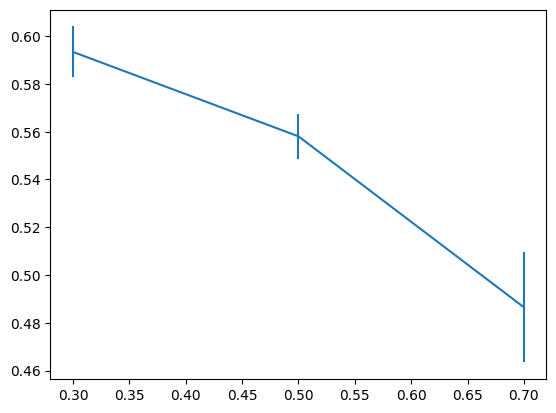

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(maes, axis=1), xerr=0., yerr=np.var(maes, axis=1))
plt.show()

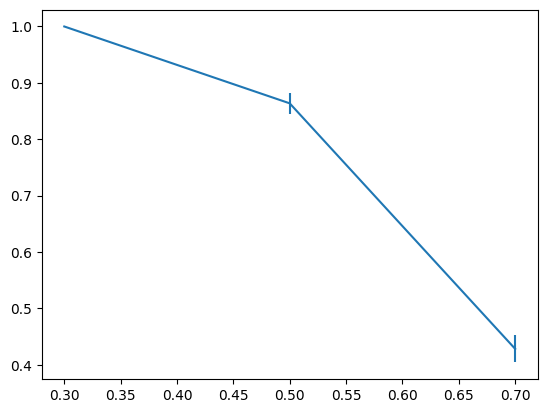

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(coverages, axis=1), xerr=0., yerr=np.var(coverages, axis=1))
plt.show()